In [1]:
# Copyright 2019-2020 Steven Mattis and Troy Butler

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde as GKDE
from luq import *
import ipywidgets as wd


In [2]:
plt.rcParams.update({'font.size': 22})
plt.rcParams.update({'axes.linewidth': 2})

np.random.seed(123456)

The model is the 1D Burger's equation, a nonlinear PDE used to model fluid dynamics:
$$q_t + \frac{1}{2} (q^2)_x = 0.$$
The domain is the interval $[0, 10]$.
We have an initial condition of the form
\begin{equation*}
q(x,0) = \begin{cases} 
      f_l & 0 \leq x\leq 3.25 -a  \\
       \frac{1}{2} ((f_l + f_r) - (f_l - f_r) \frac{(x-3.25)}{a}) & 3.25 -a < x \leq 3.25 + a \\
      f_r & 3.25 + a < x \leq 10,
   \end{cases}
\end{equation*}
where $a \in [0, 3]$ is an uncertain parameter and $f_l$ and $f_r$ are positive constants with $f_l > f_r$. 
Take $f_l = 1.5$ and $f_r = 1$.
We assume non-reflecting boundary conditions, allowing waves to pass out of the boundaries without reflection.

Text(0.5, 1.0, 'Initial Condition')

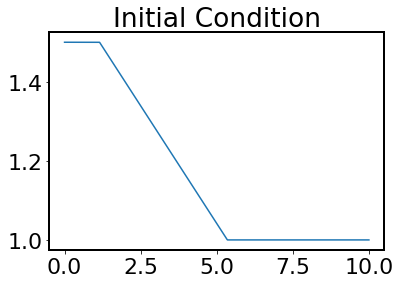

In [3]:
# Plot the initial condition given a, fl, and fr.
a = 2.1
fl = 1.5; fr = 1;
x = np.linspace(0, 10, 1000)
q0 = np.zeros(x.shape)
for i in range(x.shape[0]):
    if x[i] <= (3.25 - a):
        q0[i] = fl
    elif x[i] > (3.25 + a):
        q0[i] = fr
    else:
         q0[i] = 0.5 * ((fl + fr) - (fl - fr) * (x[i] - 3.25) / a)
fig = plt.figure()
plt.plot(x, q0)
plt.title('Initial Condition')

This system often can develop discontinuous solutions (shock waves), which complicates calculating a numerical solution. 
We use Clawpack (https://www.clawpack.org/) to calculate weak solutions to the system using a Godunov-type finite volume method with an appropriate limiter and Riemann solver. 
We use a uniform mesh with 500 elements.

The system described above forms a shock at $t = \frac{2a}{f_l - f_r}$.
The shock speed is $\frac{1}{2}(f_l + f_r)$.

We calculte the time series solution at $x=7$, i.e. $q(7,t)$ at 500 evenly spaced time steps between 0 and 10.

Two ***true*** distributions of $a$ are defined by (non-uniform)
Beta distributions and used to generate a set of time series data.

An ***initial*** uniform distribution is assumed and updated by the true time series data.

In [4]:
# Load precomputed time-series data.
times = np.loadtxt('burgers_files_v4/unif_times.txt')
predicted_time_series = np.loadtxt('burgers_files_v4/unif_series.txt')
params = np.loadtxt('burgers_files_v4/unif_params.txt')
num_samples = predicted_time_series.shape[0]

# a=5, b=2
observed_time_series = np.loadtxt('burgers_files_v5/beta_series_2_2.txt')
params_obs = np.loadtxt('burgers_files_v5/beta_params_2_2.txt')
num_obs = observed_time_series.shape[0]

if len(params.shape) == 1:
    params = params.reshape((num_samples, 1))
    params_obs = params_obs.reshape((num_obs, 1))
    
# Add noise if desired
with_noise = True
noise_stdev = 0.025

if with_noise:
    predicted_time_series += noise_stdev * np.random.randn(num_samples, times.shape[0])
    observed_time_series += noise_stdev * np.random.randn(num_obs, times.shape[0])
param_range = np.array([[0.75, 3.0]])
param_labels = [r'$a$']

In [5]:
# Use LUQ to learn dynamics and QoIs
learn = LUQ(predicted_time_series, observed_time_series, times)

# time array indices over which to use
time_start_idx = 0 #0
time_end_idx = 499 #499

# Clean data with piecewise constant linear splines
learn.clean_data(time_start_idx=time_start_idx, time_end_idx=time_end_idx,
                 num_clean_obs=500, tol=0.5*noise_stdev, min_knots=3, max_knots=4)


0 4 0.018263683384130126
1 4 0.016350482090056174
1 4 knots being used with error of 0.016350482090056174
2 4 0.016474229918252675
2 4 knots being used with error of 0.016474229918252675
3 4 0.016740252464801108
4 4 0.016610113152182707
5 4 0.01685851447346342
6 4 0.016828841917902994
7 4 0.017131575902706215
8 4 0.017397565532223134
9 4 0.017395647521789397
10 4 0.016435257793347993
11 4 0.01643047008506923
12 4 0.017937784510716384
13 4 0.018250008728233208
14 4 0.01747448737790975
15 4 0.016434676307107193
15 4 knots being used with error of 0.016434676307107193
16 4 0.017187625526672884
17 4 0.016935687065461672
18 4 0.01667748933197792
18 4 knots being used with error of 0.01667748933197792
19 4 0.017086441425779218
20 4 0.016283114344623047
21 4 0.016615600332354635
22 4 0.016394198062873823
23 4 0.015965982112644724
24 4 0.016133019149210302
25 4 0.016412421671031872
26 4 0.0162605013243692
27 4 0.01666652354717053
28 4 0.017314007267283958
29 4 0.015682563877446147
30 4 0.01672

120 4 0.016019556592201285
121 4 0.016614557712649174
122 4 0.01615348183342656
122 4 knots being used with error of 0.01615348183342656
123 4 0.0170353693971718
124 4 0.01650941683640259
125 4 0.016953038822667306
126 4 0.017072409851880632
127 4 0.016111316697702972
128 4 0.01756768019487293
129 4 0.016170865186135752
130 4 0.01647397288991852
131 4 0.01609266411139992
132 4 0.01675561689547265
133 4 0.017191670229948754
134 4 0.016169388615940535
135 4 0.016618007691859973
136 4 0.0167327120769437
137 4 0.017673565437464477
138 4 0.016751607233901598
139 4 0.016318706499285424
140 4 0.015477505812529569
141 4 0.016213818763295314
142 4 0.017825864816696575
143 4 0.016076025148160956
144 4 0.01650381200230202
145 4 0.017453724479889188
146 4 0.015526103665796369
147 4 0.016227345576534834
147 4 knots being used with error of 0.016227345576534834
148 4 0.016482113347076287
149 4 0.017428726633089864
150 4 0.016626091955368915
151 4 0.01681889131240476
151 4 knots being used with error

241 4 0.017052430801741413
242 4 0.017610518389353774
243 4 0.017695023889081087
244 4 0.01660203895294242
245 4 0.017126633275611706
246 4 0.017241364882607357
247 4 0.017265799042429104
248 4 0.016882281125618
249 4 0.016185504124313584
250 4 0.017471316124633617
251 4 0.015608725330015128
252 4 0.016434775960937502
253 4 0.016456086702305934
254 4 0.015530994997737926
255 4 0.017743485110108616
256 4 0.01685673976722424
257 4 0.015783744746360743
258 4 0.016687720367126978
259 4 0.018222197211400417
260 4 0.016493341532097396
261 4 0.01690304521093415
262 4 0.017158455739770737
263 4 0.017026338082628958
264 4 0.016698753281584437
265 4 0.017497897683750784
266 4 0.016154825509386395
267 4 0.016790595650253887
268 4 0.0169660706799666
269 4 0.01600299562590507
270 4 0.017561899262597488
271 4 0.016027566174587508
272 4 0.01717387479861948
273 4 0.017404294177576343
274 4 0.016286662291523778
275 4 0.016469170522038255
276 4 0.01722566141059242
277 4 0.015686168610314147
278 4 0.0164

362 4 0.01601292102541123
363 4 0.01708321641472215
364 4 0.01736686525062261
365 4 0.017172561541700854
366 4 0.017115312281111416
367 4 0.016942924219149877
368 4 0.016726447505307867
369 4 0.01739563166495216
370 4 0.016456170911465375
371 4 0.01777938806160579
372 4 0.016967817024604277
372 4 knots being used with error of 0.016967817024604277
373 4 0.017209705804909957
374 4 0.01701947020293058
375 4 0.014935202880474004
376 4 0.01642230971229721
377 4 0.01583831140942226
377 4 knots being used with error of 0.01583831140942226
378 4 0.016856267871831077
379 4 0.016187050613929
380 4 0.016711120818218253
380 4 knots being used with error of 0.016711120818218253
381 4 0.016834141677823662
381 4 knots being used with error of 0.016834141677823662
382 4 0.016982194067176045
383 4 0.01783703149567674
384 4 0.016332932222391006
385 4 0.01649347117617855
386 4 0.016714606576496992
386 4 knots being used with error of 0.016714606576496992
387 4 0.01787350275115369
388 4 0.016058366579147

480 4 0.017327342675492016
481 4 0.016021845542067936
482 4 0.015869706310542603
483 4 0.01668356588163549
484 4 0.015918364695927088
485 4 0.017279633711085318
486 4 0.01747815408607263
487 4 0.01709944521997626
488 4 0.01671033133577366
489 4 0.015973233478370374
490 4 0.017429968337665542
491 4 0.01757674107584931
492 4 0.017308782175857133
493 4 0.016407663219655148
494 4 0.01571361430684415
495 4 0.0168671294891349
496 4 0.016297853748855885
497 4 0.016273196372096115
498 4 0.016868102089079007
499 4 0.016807565347180444
500 4 0.016045548478712666
501 4 0.017038471726650097
502 4 0.016133035129522806
503 4 0.016514119588111668
504 4 0.016981419321861133
505 4 0.01573216100226513
506 4 0.016467472452845505
507 4 0.017709771255230822
508 4 0.016876519011193407
509 4 0.017293364953610644
510 4 0.016760667505444103
511 4 0.016927223766948527
512 4 0.01744124666521212
513 4 0.015975445174385323
514 4 0.018250301952198053
515 4 0.016918398805753992
516 4 0.01730778479228852
517 4 0.0161

600 4 0.01680646763809318
601 4 0.0177848574037861
602 4 0.016763861909441506
603 4 0.016846568202531585
604 4 0.016924076249096143
605 4 0.017279048414528295
606 4 0.017358136902305144
607 4 0.017433657384097224
608 4 0.015605103042341438
609 4 0.016281427471692034
610 4 0.015452763878846646
611 4 0.017423478600586788
612 4 0.016004045412142235
613 4 0.01686866978995531
614 4 0.016140534629640758
615 4 0.017257893143169882
616 4 0.01814415291173679
617 4 0.01678594744798446
618 4 0.016480914080086482
619 4 0.018109218540660103
620 4 0.0160071297516445
621 4 0.016835636373028852
622 4 0.01716299201585837
623 4 0.015962350573801385
624 4 0.01585205520511878
625 4 0.016700128565476202
625 4 knots being used with error of 0.016700128565476202
626 4 0.016123002908953743
627 4 0.01616344057800367
628 4 0.01604629329580635
629 4 0.016867868349564892
630 4 0.01611943779568737
631 4 0.016897032554718545
632 4 0.017561593576615173
633 4 0.01724144605173122
633 4 knots being used with error of 0

721 4 0.016471616046186747
722 4 0.01570297701753724
723 4 0.016487256682691437
724 4 0.015980072252911856
725 4 0.017100973697055856
726 4 0.01644364406111046
727 4 0.015931676192349357
728 4 0.016684083384427367
729 4 0.01746010930969671
730 4 0.016722498500678272
731 4 0.017810178454991058
732 4 0.016547764181722425
733 4 0.015699597018219432
734 4 0.016075826524287525
735 4 0.017111059393208443
736 4 0.016668595307453
737 4 0.016206603318536347
738 4 0.017367329542379083
739 4 0.016874028013537736
740 4 0.016291623625228076
741 4 0.017440435360331366
742 4 0.015885508633125215
743 4 0.017702701654332943
744 4 0.01745929380330202
745 4 0.017393095640703425
746 4 0.016880004005624717
747 4 0.016693374679594506
748 4 0.01756482809639838
749 4 0.017620687040668298
750 4 0.015997223224494428
751 4 0.01662308207710859
752 4 0.016596444573915833
753 4 0.018510483726664244
754 4 0.01583839760550658
754 4 knots being used with error of 0.01583839760550658
755 4 0.016491346345687954
756 4 0.

843 4 0.01555379077691153
844 4 0.01674745423940187
845 4 0.015414809016764466
846 4 0.016560745653571754
847 4 0.017034087275798766
848 4 0.01629665413760165
849 4 0.015364317295730233
850 4 0.018280165732186864
851 4 0.01746592958905438
852 4 0.01763812800376934
853 4 0.017273421913604436
854 4 0.01581808327285502
854 4 knots being used with error of 0.01581808327285502
855 4 0.016604680253177056
856 4 0.016756452726870687
857 4 0.01702055866531394
858 4 0.01659985338577196
859 4 0.01680848486179031
860 4 0.016378139109440443
861 4 0.017782053720712548
862 4 0.017058016391901284
863 4 0.016077220972863248
864 4 0.016467817715486357
865 4 0.01614195222973596
866 4 0.016691990752599813
867 4 0.01707009387620788
868 4 0.016267253796759706
869 4 0.017208791060086583
870 4 0.018315299279382427
871 4 0.017061753802181643
872 4 0.015827658082556106
873 4 0.016955262520394143
874 4 0.01662085898492614
875 4 0.016960528353439367
876 4 0.017340532856906943
877 4 0.017265532539250814
878 4 0.01

964 4 0.016973979861013705
965 4 0.01758513535798693
966 4 0.016256022714969943
967 4 0.016834242455233937
968 4 0.017054692443031857
969 4 0.01680425966099874
970 4 0.017900022311171934
971 4 0.017325925609250704
972 4 0.0164127693336891
973 4 0.015523510343368421
973 4 knots being used with error of 0.015523510343368421
974 4 0.016976253415854584
975 4 0.0166145182658566
975 4 knots being used with error of 0.0166145182658566
976 4 0.01709854677445705
977 4 0.01653276673869906
978 4 0.017502118248700373
979 4 0.017600920710934935
980 4 0.017497910570889362
981 4 0.01606277720469889
981 4 knots being used with error of 0.01606277720469889
982 4 0.01599079004144168
983 4 0.01653064705611044
984 4 0.016475693800027814
985 4 0.016380635449913354
986 4 0.016283883793005306
987 4 0.016045750610510248
988 4 0.01650687974480033
989 4 0.016243033407975244
989 4 knots being used with error of 0.016243033407975244
990 4 0.01711402377514425
991 4 0.01638961491547179
992 4 0.016462391862370147
99

84 4 0.016018806844479982
85 4 0.016226301335005258
86 4 0.017093596943193578
87 4 0.01716182022451439
88 4 0.01702358168693851
89 4 0.01672657870120788
90 4 0.017926692021255127
91 4 0.01716976829988689
92 4 0.015932499829417298
93 4 0.01694237376280592
94 4 0.01581945844033728
95 4 0.016861107783068454
96 4 0.017316361118979537
97 4 0.017051926084810917
98 4 0.01698474765670946
99 4 0.016968609437687753
100 4 0.01734622176343006
101 4 0.015957852075002277
102 4 0.01648440240434192
103 4 0.016760709124138254
104 4 0.015438676463643275
105 4 0.01719016833664878
106 4 0.0167051385709709
107 4 0.014957585942053861
108 4 0.01800187960602618
109 4 0.016339614403503212
110 4 0.016289401557183652
111 4 0.01653074917877717
112 4 0.016485522441826373
113 4 0.016304998910798833
114 4 0.018179312879126778
115 4 0.017511841884456824
116 4 0.017208077119224785
117 4 0.01685434113268551
118 4 0.01640538062389101
119 4 0.016240840813719855
120 4 0.016861856783278346
121 4 0.016411689323139734
122 4 

204 4 0.016408445139281937
205 4 0.016457191275201507
206 4 0.017710361276756095
207 4 0.015281524570636858
207 4 knots being used with error of 0.015281524570636858
208 4 0.01737215450385682
209 4 0.01676012853393093
210 4 0.017339905290427584
211 4 0.016310623431452467
212 4 0.01754806824278417
213 4 0.017312820640544624
214 4 0.017219518656188575
215 4 0.01717641907772564
216 4 0.017054318053079054
217 4 0.017224036071345438
218 4 0.016634910231223394
219 4 0.016459528347886405
220 4 0.016219400801032725
221 4 0.017020707989839307
222 4 0.016528434767149828
223 4 0.016593023553124104
224 4 0.01752032511813677
225 4 0.017618706961890995
226 4 0.016550240644828348
227 4 0.016799940047614877
228 4 0.016467337539139152
229 4 0.01638835028263982
230 4 0.016838008529338498
231 4 0.017354890185272105
232 4 0.017670137825980335
233 4 0.017627176570675855
234 4 0.016824661827479374
235 4 0.017665322102443464
236 4 0.016711283126539845
237 4 0.016343883083245088
238 4 0.017057257973624396
239

325 4 0.016210124242544238
326 4 0.01650587283969426
327 4 0.016080165360092526
328 4 0.016780064713794018
329 4 0.01621917563572462
330 4 0.01797588852511646
331 4 0.01707089174838978
332 4 0.01837350758855144
333 4 0.017215471305014704
334 4 0.01717936675836877
335 4 0.016586330411805707
336 4 0.017530707599713154
337 4 0.01712853858115582
338 4 0.017572902245734386
339 4 0.0169518344909278
340 4 0.0156353553903851
341 4 0.015347056537442668
342 4 0.016956092242961837
343 4 0.015895557306591385
344 4 0.016267134862071476
345 4 0.01738492352690712
346 4 0.017092994920196235
347 4 0.01611585828103106
348 4 0.016929831976435397
349 4 0.016034351827081447
350 4 0.01675481828608071
351 4 0.016358895610639284
352 4 0.01631940404386802
353 4 0.01672209275098933
354 4 0.01634450159130497
355 4 0.01673051948704589
356 4 0.01675311059799411
357 4 0.016607126644160662
358 4 0.017269151125646424
359 4 0.016396959275796326
360 4 0.016229919310748266
361 4 0.016157479935340748
362 4 0.017303611712

450 4 0.01674793624651839
451 4 0.016621186311265503
451 4 knots being used with error of 0.016621186311265503
452 4 0.01679014327898753
453 4 0.016891550562093665
454 4 0.016666599343395348
455 4 0.017771883370754183
456 4 0.016545693526597703
457 4 0.01637865417480668
458 4 0.01672080099501776
459 4 0.016839896093891134
460 4 0.015799251488089337
461 4 0.016165589816861264
462 4 0.016861136259421962
463 4 0.01822397105044111
464 4 0.017224658804769692
465 4 0.017271073860396394
466 4 0.01721603134276395
467 4 0.017058291998555932
468 4 0.01736646829364781
469 4 0.016495078397061685
470 4 0.016984655537348774
471 4 0.016597270781099033
472 4 0.017252264182375993
473 4 0.017862278985707216
474 4 0.016530187275533785
475 4 0.016297649215886695
476 4 0.01686812857140192
477 4 0.016172206138291526
478 4 0.017377624512081028
479 4 0.016809566890255822
480 4 0.016568887647923053
481 4 0.01677005084388494
482 4 0.016705321276590447
483 4 0.017085444050100002
484 4 0.017548139971337317
485 4 

(array([[0.97648421, 0.97695291, 0.9774216 , ..., 1.49551659, 1.49547042,
         1.49542425],
        [0.9789521 , 0.97991297, 0.98087384, ..., 1.49474157, 1.4945985 ,
         1.49445542],
        [0.96827212, 0.96922745, 0.97018278, ..., 1.49903568, 1.49891177,
         1.49878785],
        ...,
        [0.97362767, 0.97448348, 0.97533929, ..., 1.50003088, 1.50007586,
         1.50012084],
        [0.99767095, 0.99769032, 0.99770969, ..., 1.50252188, 1.50251972,
         1.50251756],
        [0.97820241, 0.97884993, 0.97949746, ..., 1.4893891 , 1.48918041,
         1.48897172]]),
 array([[0.99443909, 0.99451457, 0.99459005, ..., 1.49218174, 1.49205594,
         1.49193014],
        [0.99656308, 0.99660839, 0.99665369, ..., 1.49754252, 1.49754799,
         1.49755345],
        [0.99585363, 0.99589368, 0.99593374, ..., 1.50697483, 1.50701272,
         1.50705062],
        ...,
        [0.9966331 , 0.9967173 , 0.99680151, ..., 1.5122296 , 1.51237005,
         1.51251051],
        [0.9

In [6]:
# Learn and classify dynamics.
learn.dynamics(cluster_method='kmeans', kwargs={'n_clusters': 2, 'n_init': 10})

0.011 misclassification rate for  {'kernel': 'linear'}
0.038 misclassification rate for  {'kernel': 'rbf'}
0.022 misclassification rate for  {'kernel': 'poly'}
0.4170000000000001 misclassification rate for  {'kernel': 'sigmoid'}
Best classifier is  {'kernel': 'linear'}
Misclassification rate is  0.011


Text(0.5, 1.0, 'Approximating Dynamics')

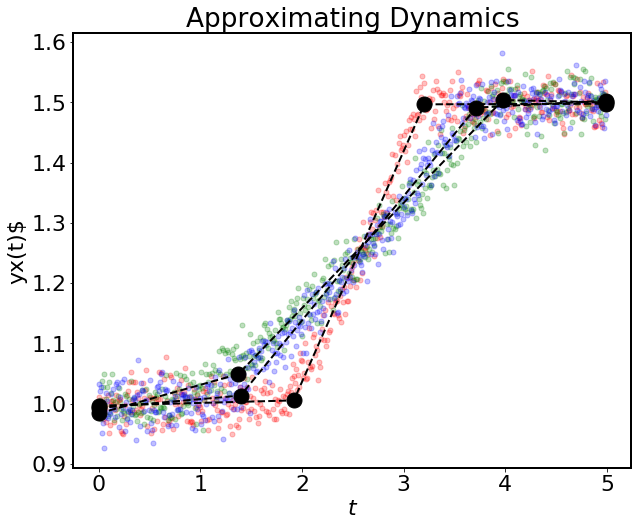

In [7]:
fig = plt.figure(figsize=(10,8))

# chosen_obs = [109, 8]

chosen_obs = [1, 3, 6]  #7]
colors = ['r', 'g', 'b']

for i, c in zip(chosen_obs,colors):
    plt.plot(learn.times[time_start_idx:time_end_idx+1], learn.observed_time_series[i,time_start_idx:time_end_idx+1],color=c, linestyle='none', marker='.', markersize=10, alpha=0.25)
    
for i in chosen_obs:
    num_i_knots = int(0.5*(2+len(learn.obs_knots[i])))
    knots = np.copy(learn.obs_knots[i][num_i_knots:])
    knots = np.insert(knots, 0, learn.clean_times[0])
    knots = np.append(knots, learn.clean_times[-1])
    plt.plot(knots, learn.obs_knots[i][:num_i_knots], 'k', linestyle='dashed', markersize=15, marker='o', linewidth=2)
    
plt.xlabel('$t$')
plt.ylabel('yx(t)$')
plt.title('Approximating Dynamics') 

Text(0.5, 1.0, 'Generating Clean Data')

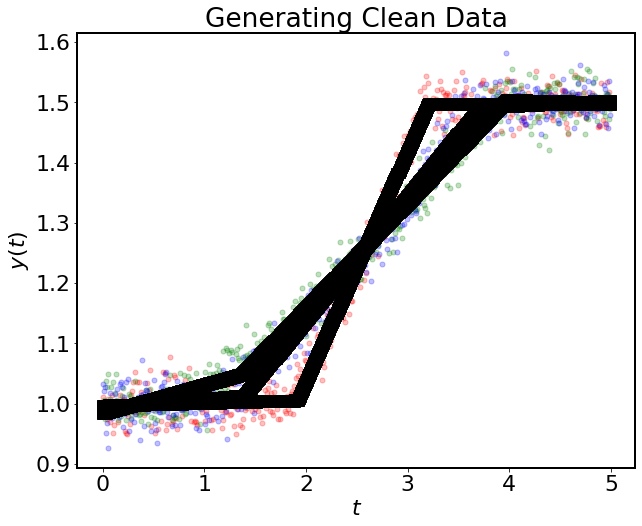

In [8]:
fig = plt.figure(figsize=(10,8))

for i, c in zip(chosen_obs,colors):
    plt.plot(learn.times[time_start_idx:time_end_idx+1], learn.observed_time_series[i,time_start_idx:time_end_idx+1],color=c, linestyle='none', marker='.', markersize=10, alpha=0.25)
    
for i in chosen_obs:
    plt.plot(learn.clean_times, learn.clean_obs[i,:],'k', linestyle='none', marker='s', 
            markersize=12)
    
plt.xlabel('$t$')
plt.ylabel('$y(t)$')
plt.title('Generating Clean Data') 

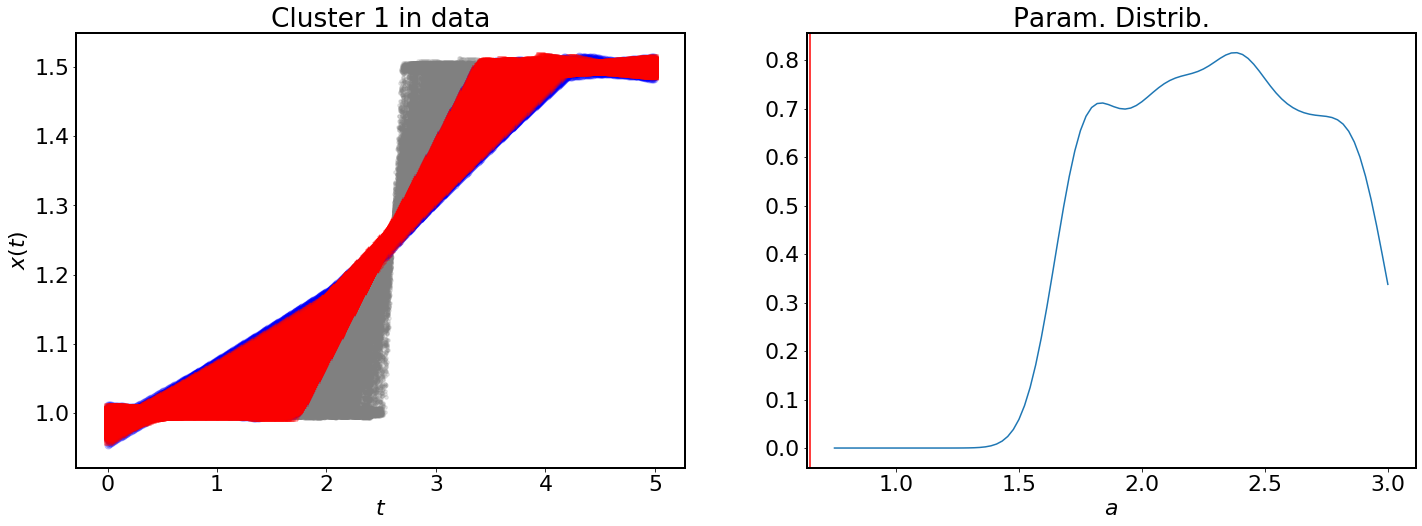

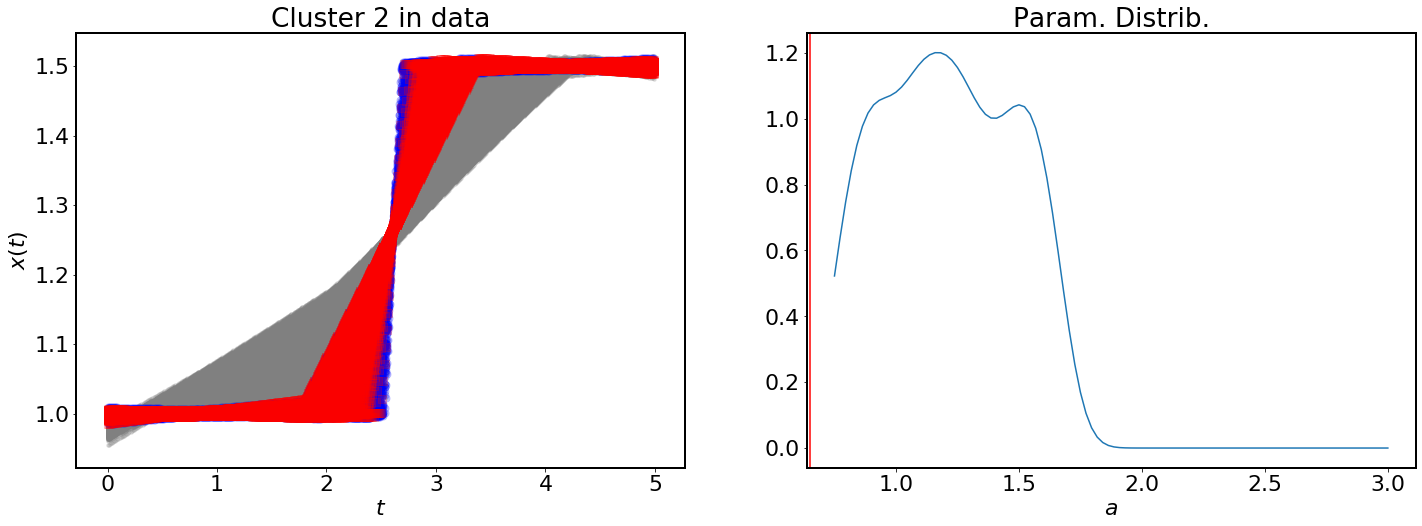

In [9]:
# # Plot clusters of predicted time series
num_clean_obs = learn.clean_times.shape[0]
for j in range(learn.num_clusters):
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(24,8), gridspec_kw={'width_ratios': [1, 1]}) 
    ax1.scatter(np.tile(learn.clean_times,num_samples).reshape(num_samples, num_clean_obs), 
                learn.clean_predictions, 50, c='gray', marker='.', alpha=0.2)
    idx = np.where(learn.predict_labels == j)[0]
    ax1.scatter(np.tile(learn.clean_times,len(idx)).reshape(len(idx),num_clean_obs), 
                learn.clean_predictions[idx,:], 50, c='b', marker='o', alpha=0.2)
    idx2 = np.where(learn.obs_labels == j)[0]    
    ax1.scatter(np.tile(learn.clean_times,len(idx2)).reshape(len(idx2),num_clean_obs), 
                learn.clean_obs[idx2, :], 50, c='r', marker='s', alpha=0.2)
    ax1.set(title='Cluster ' + str(j+1) + ' in data')
    ax1.set_xlabel('$t$')
    ax1.set_ylabel('$x(t)$')
    
    xs = np.linspace(param_range[0, 0], param_range[0, 1], 100)
    ax2.plot(xs, GKDE(params[idx].flat[:])(xs))
    ax2.axvline(x=.65, ymin=0.0, ymax=1.0, color='r')
    ax2.set(xlabel=param_labels[0], title='Param. Distrib.')
    
#     ax2.scatter(params[:,0], params[:,1], 30, c='gray', marker='.', alpha=0.2)
#     ax2.scatter(params[idx,0], params[idx,1], 50, c='blue', marker='o')
#     ax2.set(title='Cluster ' + str(j+1) + ' in parameters')
#     ax2.set_ylabel(param_labels[1])
#     ax2.set_xlabel(param_labels[0])
#     xs = np.linspace(param_range[0,0], param_range[0,1], 100)
#     ys1 = np.sqrt(0.5*(1.0 - np.sqrt(1.0 - 8.0*xs) -2.0*xs))
#     ys2 = np.sqrt(0.5*(1.0 + np.sqrt(1.0 - 8.0*xs) -2.0*xs))
#     ax2.plot(xs, ys1, 'r-', linewidth=3)
#     ax2.plot(xs, ys2, 'r-', linewidth=3)
    fig.tight_layout

In [10]:
# # Plot clusters of predicted time series
# for j in range(learn.num_clusters):
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,2.5), gridspec_kw={'width_ratios': [3, 1]}) #(figsize=(10,5))
#     ps = []
#     for i in range(num_samples):
#         if learn.predict_labels[i] == j:
#             ps.append(params[i,0])
#             ax1.plot(learn.clean_times, learn.clean_predictions[i, :])
#             #ax1.plot(times[time_start_idx : time_end_idx + 1], predicted_time_series[i, time_start_idx : time_end_idx + 1])
#     ax1.set(title='Cluster ' + str(j))
#     xs = np.linspace(param_range[0, 0], param_range[0,1], 100)
#     ax2.plot(xs, GKDE(ps)(xs))
#     ax2.set(xlabel=param_labels[0], title='Param. Distrib.')

In [11]:
# # Plot observed and predicted clusters
# for j in range(learn.num_clusters):
#     plt.figure()
#     cluster_num = j
#     for i in range(num_samples):
#         if learn.predict_labels[i] == cluster_num:
#             plt.plot(learn.clean_times, learn.clean_predictions[i,:],'b*')
#     for i in range(num_obs):
#         if learn.obs_labels[i] == cluster_num:
#             plt.plot(learn.clean_times, learn.clean_obs[i,:],'ro')

In [12]:
# Find best KPCA transformation for given number of QoI and transform time series data.
predict_map, obs_map = learn.learn_qois_and_transform(num_qoi=1,
                                                     proposals=({'kernel': 'linear'}, {'kernel': 'rbf'},
                             {'kernel': 'sigmoid'}, {'kernel': 'cosine'})) #variance_rate=0.95) #num_qoi=1)

1 principal components explain 64.3513% of variance for cluster 0 with {'kernel': 'linear'}
1 principal components explain 24.6513% of variance for cluster 0 with {'kernel': 'rbf'}
1 principal components explain 67.5589% of variance for cluster 0 with {'kernel': 'sigmoid'}
1 principal components explain 53.6840% of variance for cluster 0 with {'kernel': 'cosine'}
Best kPCA for cluster  0  is  {'kernel': 'sigmoid'}
1 principal components explain 67.5589% of variance.
1 principal components explain 29.2163% of variance for cluster 1 with {'kernel': 'linear'}
1 principal components explain 11.0089% of variance for cluster 1 with {'kernel': 'rbf'}
1 principal components explain 26.2849% of variance for cluster 1 with {'kernel': 'sigmoid'}
1 principal components explain 26.4559% of variance for cluster 1 with {'kernel': 'cosine'}
Best kPCA for cluster  1  is  {'kernel': 'linear'}
1 principal components explain 29.2163% of variance.


In [13]:
%reset -f out

def plot_gap(all_eig_vals, n, cluster):
    fig = plt.figure(figsize=(10,10))
    fig.clear()
    #Plotting until maximum number of knots
    eig_vals = all_eig_vals[cluster].lambdas_[0:10]
    plt.semilogy(np.arange(np.size(eig_vals))+1,eig_vals/np.sum(eig_vals)*100, Marker='.', MarkerSize=20, linestyle='')
    plt.semilogy(np.arange(np.size(eig_vals))+1,eig_vals[n]/np.sum(eig_vals)*100*np.ones(np.size(eig_vals)), 'k--')
    plt.semilogy(np.arange(np.size(eig_vals))+1,eig_vals[n+1]/np.sum(eig_vals)*100*np.ones(np.size(eig_vals)), 'r--')
    plt.text(n+1, eig_vals[n]/np.sum(eig_vals)*150, 
             r'%2.3f' %(np.sum(eig_vals[0:n+1])/np.sum(eig_vals)*100) + '% of variation explained by first ' + '%1d' %(n+1) + ' PCs.', 
                                                               {'color': 'k', 'fontsize': 20})
    plt.text(n+2, eig_vals[n+1]/np.sum(eig_vals)*150, 
             r'Order of magnitude of gap is %4.2f.' %(np.log10(eig_vals[n])-np.log10(eig_vals[n+1])), 
                                                               {'color': 'r', 'fontsize': 20})
    s = 'Determining QoI for cluster #%1d' %(cluster+1)
    plt.title(s)
    plt.xlabel('Principal Component #')
    plt.ylabel('% of Variation')
    plt.xlim([0.1, np.size(eig_vals)+1])
    plt.ylim([0,500])


wd.interact(plot_gap, all_eig_vals=wd.fixed(learn.kpcas),
            n = wd.IntSlider(value=0, min=0, max=5),
            cluster = wd.IntSlider(value=0, min=0, max=learn.num_clusters-1))

Flushing output cache (4 entries)


interactive(children=(IntSlider(value=0, description='n', max=5), IntSlider(value=0, description='cluster', ma…

<function __main__.plot_gap(all_eig_vals, n, cluster)>

In [14]:
# Generate kernel density estimates on new QoI
learn.generate_kdes()
# Calculate rejection rates for each cluster and print averages.
r_vals=learn.compute_r()

Diagnostic for clusters [sample average of ratios in each cluster]: [1.0106969868018871, 0.9874828069631364]


In [15]:
# Compute marginal probablities for each parameter and initial condition.
param_marginals = []
true_param_marginals = []
lam_ptr = []
cluster_weights = []
for i in range(learn.num_clusters):
    lam_ptr.append(np.where(learn.predict_labels == i)[0])
    cluster_weights.append(len(np.where(learn.obs_labels == i)[0]) / num_obs)

for i in range(params.shape[1]):
    true_param_marginals.append(GKDE(params_obs[:,i]))
    param_marginals.append([])
    for j in range(learn.num_clusters):
        param_marginals[i].append(GKDE(params[lam_ptr[j], i], weights=learn.r[j]))
        

In [16]:
# uniform distribution
def unif_dist(x, p_range):
    y = np.zeros(x.shape)
    val = 1.0/(p_range[1] - p_range[0])
    for i, xi in enumerate(x):
        if xi < p_range[0] or xi >  p_range[1]:
            y[i] = 0
        else:
            y[i] = val
    return y

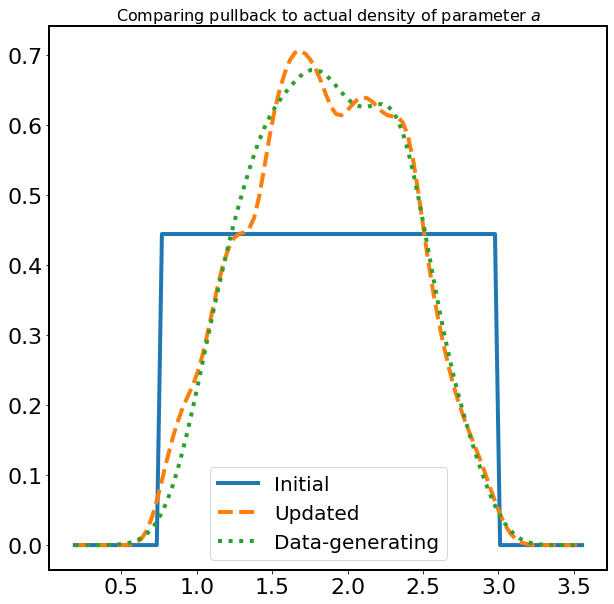

In [17]:
# Plot predicted marginal densities for parameters

for i in range(params.shape[1]):
    fig = plt.figure(figsize=(10,10))
    fig.clear()
    x_min = min(min(params[:, i]), min(params_obs[:, i]))
    x_max = max(max(params[:, i]), max(params_obs[:, i]))
    delt = 0.25*(x_max - x_min)
    x = np.linspace(x_min-delt, x_max+delt, 100)
    plt.plot(x, unif_dist(x, param_range[i, :]),
         label = 'Initial', linewidth=4)
    mar = np.zeros(x.shape)
    for j in range(learn.num_clusters):
        mar += param_marginals[i][j](x) * cluster_weights[j]
    plt.plot(x, mar, label = 'Updated', linewidth=4, linestyle='dashed')
    plt.plot(x, true_param_marginals[i](x), label = 'Data-generating', 
             linewidth=4, linestyle='dotted')
    plt.title('Comparing pullback to actual density of parameter ' + param_labels[i], fontsize=16)
    plt.legend(fontsize=20)

### Compute TV metric between densities

In [18]:
import scipy.integrate.quadrature as quad

In [19]:
def param_init_error(x):
    return np.abs(unif_dist(x,param_range[param_num, :])-true_param_marginals[param_num](x))

for i in range(params.shape[1]):
    param_num=i
    TV_metric = quad(param_init_error,param_range[i,0],param_range[i,1],maxiter=1000)
    print(TV_metric)

(0.4305616473897793, 9.868086736641857e-09)


In [20]:
def param_update_KDE_error(x):
    mar = np.zeros(x.shape)
    for j in range(learn.num_clusters):
        mar += param_marginals[param_num][j](x) * cluster_weights[j]
    return np.abs(mar-true_param_marginals[param_num](x))

for i in range(params.shape[1]):
    param_num=i
    TV_metric = quad(param_update_KDE_error,param_range[i,0],param_range[i,1],maxiter=1000)
    print(TV_metric)

(0.05468342364740572, 1.627411885807284e-10)


In [21]:
from scipy.stats import beta 

In [22]:
true_a = 2.0
true_b = 2.0
def KDE_error(x):
    true_beta = beta(a=true_a, b=true_b,loc=param_range[i,0],scale=param_range[i,1]-param_range[i,0])
    return np.abs(true_beta.pdf(x)-true_param_marginals[param_num](x))

for i in range(params.shape[1]):
    param_num=i
    TV_metric = quad(KDE_error,param_range[i,0],param_range[i,1],maxiter=1000)
    print(TV_metric)

(0.05851673412391385, 8.207582363750632e-09)


In [23]:
# Load precomputed time-series data at x=9.5.
# a=2, b=5
predicted_time_series2 = np.loadtxt('burgers_files_v4/unif_series2.txt')
observed_time_series2 = np.loadtxt('burgers_files_v5/beta_series2_2_2.txt')
params_obs2 = np.loadtxt('burgers_files_v5/beta_params_2_2.txt')
num_obs2 = observed_time_series.shape[0]
params_obs2 = params_obs2.reshape((num_obs2, 1))

# Add noise if desired
with_noise = True
noise_stdev = 0.025

if with_noise:
    predicted_time_series2 += noise_stdev * np.random.randn(num_samples, times.shape[0])
    observed_time_series2 += noise_stdev * np.random.randn(num_obs2, times.shape[0])


In [24]:
# Use LUQ to learn dynamics and QoIs
learn2 = LUQ(predicted_time_series2, observed_time_series2, times)

# time array indices over which to use
time_start_idx = 250 #0
time_end_idx = 749 #499

# Clean data with piecewise constant linear splines
learn2.clean_data_tol(time_start_idx=time_start_idx, time_end_idx=time_end_idx,
                 num_clean_obs=500, tol=0.5*noise_stdev, min_knots=3, max_knots=4)


0 3 0.04086086104741878
0 4 0.01710403146217024
1 3 0.024701081950705035
1 4 0.01631658610422094
2 3 0.02764269608534734
2 4 0.01709441618235167
3 3 0.07361873626762208
3 4 0.016244308826216074
4 3 0.04162058660355439
4 4 0.016654504580157353
5 3 0.03999074412472803
5 4 0.016303011095457336
6 3 0.03171002745841898
6 4 0.016908856169664047
7 3 0.057334622142433816
7 4 0.014932041363709188
8 3 0.07370123140022879
8 4 0.015423840186309847
9 3 0.04500704678607274
9 4 0.017137721491251725
10 3 0.07322335940218547
10 4 0.01529138447802748
11 3 0.03634480513587338
11 4 0.016336920502331296
12 3 0.03980303390130812
12 4 0.016538792241267336
13 3 0.07472474713327273
13 4 0.0169078739923739
14 3 0.03668044708027631
14 4 0.016804200654112193
15 3 0.02776484596508809
15 4 0.016051484999522875
16 3 0.06182589549000842
16 4 0.015005404064263083
17 3 0.03502162361970409
17 4 0.01762664315083392
18 3 0.027951108922927403
18 4 0.01817598842537719
19 3 0.044301149914526015
19 4 0.016211183296096904
20 3

89 3 0.04025996615168108
89 4 0.016986336401649794
90 3 0.04005921110930767
90 4 0.017008556607343395
91 3 0.030213540144809606
91 4 0.016352889158739257
92 3 0.0655103018544637
92 4 0.015024883545182834
93 3 0.02746697118768333
93 4 0.016505434404428986
94 3 0.06357069379250511
94 4 0.01602901169811303
95 3 0.03570310106566584
95 4 0.016303197866753598
96 3 0.057612173417547
96 4 0.016359399245215917
97 3 0.055435943163888377
97 4 0.017278873300388263
98 3 0.04962152334821933
98 4 0.016645395865725235
99 3 0.050372757098341214
99 4 0.01632424800547182
100 3 0.06390728608956536
100 4 0.015803478802099646
101 3 0.04340545718948329
101 4 0.01743131487958792
102 3 0.07246992672011417
102 4 0.016870535954546895
103 3 0.0264424419873685
103 4 0.016835549469416983
104 3 0.0731163099508488
104 4 0.015112608532474398
105 3 0.05626822848108579
105 4 0.016226621639985075
106 3 0.06631807332217758
106 4 0.016042608762315124
107 3 0.04481923906968197
107 4 0.015476809185928803
108 3 0.058381835096

178 4 0.016508700717231827
179 3 0.049633426172730276
179 4 0.015689411660556693
180 3 0.07317357225791943
180 4 0.015084619003288285
181 3 0.07259321126381515
181 4 0.015432381052513554
182 3 0.027202904612583362
182 4 0.017411516816626792
183 3 0.039201761511491774
183 4 0.016510088562369817
184 3 0.07202947994228884
184 4 0.01681264149302693
185 3 0.03774124026597755
185 4 0.01620183827384508
186 3 0.06184891435412998
186 4 0.016571550546961758
187 3 0.03278070280308737
187 4 0.018328444405077145
188 3 0.042195137666096255
188 4 0.016828052120004704
189 3 0.06025001322770374
189 4 0.01654445709925751
190 3 0.06722302168079251
190 4 0.015462784640845832
191 3 0.03982629823825443
191 4 0.017242722422217537
192 3 0.039870984017341425
192 4 0.016725601337944478
193 3 0.04517534024744647
193 4 0.0169992546846534
194 3 0.04175418138209592
194 4 0.017443036333875235
195 3 0.04353021721519655
195 4 0.016341390139092866
196 3 0.032509084356402804
196 4 0.016608505703090897
197 3 0.0520037131

271 3 0.030568549497237345
271 4 0.01634264837725878
272 3 0.03978547564445535
272 4 0.016694764459695914
273 3 0.05158247792261108
273 4 0.016633982258196685
274 3 0.07255085767089522
274 4 0.01591020088293294
275 3 0.03326713658003554
275 4 0.01729081331068987
276 3 0.056633779305811434
276 4 0.016303963638450707
277 3 0.07310266646555787
277 4 0.016432841664772217
278 3 0.072722093301644
278 4 0.015924835919307302
279 3 0.038435999534985624
279 4 0.015608801712069045
280 3 0.07274900287707323
280 4 0.015791648228741736
281 3 0.031852945323989496
281 4 0.017135329195933444
282 3 0.04534962863414308
282 4 0.016580006899723342
283 3 0.055665496112247484
283 4 0.014809716082084994
284 3 0.038319905849976854
284 4 0.01595579233117401
285 3 0.038439479254196336
285 4 0.015877315387944374
286 3 0.03936871795481974
286 4 0.01681907911546795
287 3 0.05929955243224398
287 4 0.01627048422657637
288 3 0.04037495846142178
288 4 0.016357070969976843
289 3 0.04574143388002986
289 4 0.0157990501075

358 3 0.026683285266962082
358 4 0.016598155744914002
359 3 0.04254672447007437
359 4 0.016907526655697894
360 3 0.04613235234540551
360 4 0.015675316133690668
361 3 0.07467938864136404
361 4 0.01578799656686986
362 3 0.02720055419870146
362 4 0.016449127204695064
363 3 0.08280042211811728
363 4 0.015933850893233913
364 3 0.05885916917754485
364 4 0.016641291321752308
365 3 0.05568528590332965
365 4 0.016490914070955234
366 3 0.0486665741278
366 4 0.0167418772314424
367 3 0.05708730590847313
367 4 0.017568199660401147
368 3 0.07485651578039886
368 4 0.017256440625269046
369 3 0.032433071872899406
369 4 0.016854107782745986
370 3 0.05223645679507164
370 4 0.01652457363550707
371 3 0.058997659994598266
371 4 0.016690667968815093
372 3 0.03489993149861438
372 4 0.016925092662172417
373 3 0.06456639347096395
373 4 0.01585592994997217
374 3 0.04718842628056472
374 4 0.015890562333004052
375 3 0.07324675287367066
375 4 0.01669936317266647
376 3 0.03935950179467955
376 4 0.015977511363578716


449 3 0.07327025280769649
449 4 0.015280333569917464
450 3 0.07331708781262669
450 4 0.015882756818088293
451 3 0.07381447896033377
451 4 0.015479279989575828
452 3 0.02615587380396737
452 4 0.017141786401409304
453 3 0.03425763923529118
453 4 0.01583865948710784
454 3 0.07269541772206893
454 4 0.01630559317379982
455 3 0.02540010341081581
455 4 0.01714154692840323
456 3 0.025034415570663365
456 4 0.016618942931968497
457 3 0.0609272707888934
457 4 0.01602241629429076
458 3 0.05581673679007346
458 4 0.01528011929733657
459 3 0.07365957082979248
459 4 0.015005434291727638
460 3 0.07372206462926843
460 4 0.01508091204237691
461 3 0.0727777304839603
461 4 0.015573975439168648
462 3 0.05103282608918485
462 4 0.01774092940323773
463 3 0.0397624947897649
463 4 0.01771485737550843
464 3 0.0730038906671384
464 4 0.01572184166873219
465 3 0.07351521067914842
465 4 0.01563695940167219
466 3 0.08226603922294551
466 4 0.016071920081570483
467 3 0.03730000656983543
467 4 0.01622508833769295
468 3 0

537 3 0.07256006573120186
537 4 0.016119494804107074
538 3 0.029731784581671198
538 4 0.017708407194982193
539 3 0.07314978066289854
539 4 0.01602040684462818
540 3 0.051033933211538984
540 4 0.01644993036784509
541 3 0.06343793028815453
541 4 0.016407216937825618
542 3 0.07404211950041237
542 4 0.01603161019579332
543 3 0.0741671198898764
543 4 0.01458557141934552
544 3 0.03192771351720061
544 4 0.017679341529980106
545 3 0.07368468703791388
545 4 0.015460927598267485
546 3 0.029159417925236797
546 4 0.015920576928654447
547 3 0.025468867182627076
547 4 0.017119596655308256
548 3 0.047184913893375896
548 4 0.015160901690254226
549 3 0.038298637843488074
549 4 0.01717968686312721
550 3 0.07347758581162016
550 4 0.016207309012336562
551 3 0.055418005189984354
551 4 0.015924907515413457
552 3 0.05120888017148449
552 4 0.016713868724273273
553 3 0.031162679814219923
553 4 0.016036285009348807
554 3 0.074222965851902
554 4 0.016038973550493538
555 3 0.07022044301900492
555 4 0.015539486841

625 4 0.016371646012577873
626 3 0.03856205948160645
626 4 0.016683614000167775
627 3 0.0697411065384502
627 4 0.01687731236328386
628 3 0.06534324057141114
628 4 0.015768547895663097
629 3 0.04975994238475778
629 4 0.017307350936921487
630 3 0.07313184912197297
630 4 0.01571177299443539
631 3 0.06843561374079382
631 4 0.016666919904268676
632 3 0.05434742378830375
632 4 0.016388362149439468
633 3 0.02935572095846214
633 4 0.016400542510286536
634 3 0.0734072788814612
634 4 0.015116722082472812
635 3 0.07386967356880679
635 4 0.01625927236504349
636 3 0.0737543056841308
636 4 0.015398025496470421
637 3 0.02653888314947413
637 4 0.016170808622125773
638 3 0.03715801563332525
638 4 0.01696918141026765
639 3 0.0591544197793427
639 4 0.016635902453357478
640 3 0.03820609027000684
640 4 0.016207976889060248
641 3 0.03986078710340774
641 4 0.015361596271427738
642 3 0.028435094824536714
642 4 0.01617636087880046
643 3 0.07166760448202349
643 4 0.016038067695257785
644 3 0.07212047037812415
6

712 3 0.07402369882313446
712 4 0.014818717237559974
713 3 0.036003097564492166
713 4 0.016784870140993433
714 3 0.06074234199529084
714 4 0.015866815432970114
715 3 0.07306022974794935
715 4 0.01726650454278517
716 3 0.05938690486480079
716 4 0.015838495855349372
717 3 0.025197206589120596
717 4 0.01754670988168832
718 3 0.05072317845128647
718 4 0.01592321330960586
719 3 0.02433067458315288
719 4 0.017270031205928887
720 3 0.07258687225930784
720 4 0.01638471526627413
721 3 0.0549936102691709
721 4 0.016072137825162387
722 3 0.02839293246499634
722 4 0.017983082610112798
723 3 0.027639540331441746
723 4 0.016623861898970034
724 3 0.06248616137526128
724 4 0.01588795295445307
725 3 0.035419310270062836
725 4 0.017247698308974727
726 3 0.05865798184815166
726 4 0.01586756709260702
727 3 0.0738528188025335
727 4 0.016319763018733696
728 3 0.03070851544750073
728 4 0.016792417159669927
729 3 0.06328103716646544
729 4 0.01634300150943686
730 3 0.06207631862430224
730 4 0.01690660696433801

801 3 0.07462684778423478
801 4 0.01642271907274819
802 3 0.0735553377096969
802 4 0.016309127357414684
803 3 0.02722747537447116
803 4 0.017311857203763027
804 3 0.07091334480617176
804 4 0.017412341429296905
805 3 0.03050531973016612
805 4 0.016452657553572825
806 3 0.04867953805802408
806 4 0.01674111315318448
807 3 0.05320793289383677
807 4 0.016839165310340035
808 3 0.07311890521276705
808 4 0.015316464106940389
809 3 0.07340362255789132
809 4 0.015836422953809447
810 3 0.07001557447190562
810 4 0.01632023522286586
811 3 0.05732382480072867
811 4 0.016815250642092768
812 3 0.07286752516786295
812 4 0.01569888665429551
813 3 0.048039854423246486
813 4 0.017268823778787884
814 3 0.07297090021461917
814 4 0.015015077274340623
815 3 0.07283459137354231
815 4 0.015370442541043215
816 3 0.08030139348207758
816 4 0.016566340501814325
817 3 0.07233024924157765
817 4 0.01635484947911215
818 3 0.08034444478945472
818 4 0.016456069930899726
819 3 0.0740567190944059
819 4 0.0166876921480074
8

888 3 0.0711916006621353
888 4 0.015617439534863614
889 3 0.03234377041110252
889 4 0.01656300201554371
890 3 0.04537305153703495
890 4 0.01674899890214682
891 3 0.07191295655691472
891 4 0.01537782685192739
892 3 0.06534580108754491
892 4 0.01513314084049199
893 3 0.07248209139373772
893 4 0.01638099394547859
894 3 0.07388053644111958
894 4 0.015974202636433784
895 3 0.07289342271082581
895 4 0.016627716377577408
896 3 0.05834174336860548
896 4 0.01605718935417784
897 3 0.02663744821118535
897 4 0.01673066231387539
898 3 0.06524243588077447
898 4 0.015698903645532378
899 3 0.04372538516452865
899 4 0.01610008938883501
900 3 0.039751737995343435
900 4 0.017041796751893424
901 3 0.030107994128419534
901 4 0.017622478014236304
902 3 0.07333270505726838
902 4 0.016186156263725607
903 3 0.028027983610125512
903 4 0.017249408592104783
904 3 0.07004675799336636
904 4 0.016323102764549454
905 3 0.028457032108696035
905 4 0.016953426418903364
906 3 0.02761372531391063
906 4 0.01640481831051348

980 4 0.01636609658096747
981 3 0.028397908448223277
981 4 0.018560706306135263
982 3 0.06672856540092173
982 4 0.016769224007001985
983 3 0.0654441568782204
983 4 0.016232004747619978
984 3 0.059984333664843396
984 4 0.01582357941109951
985 3 0.07305937299756163
985 4 0.015795657918327276
986 3 0.04332551624883793
986 4 0.016543059241897206
987 3 0.05826891302944166
987 4 0.016255312871335442
988 3 0.05851731074702584
988 4 0.01635458499059078
989 3 0.026224191707171548
989 4 0.016614581236784817
990 3 0.04636522426079818
990 4 0.01731841399845809
991 3 0.0744556683391853
991 4 0.01614706206139669
992 3 0.055110022340283935
992 4 0.016670669179488826
993 3 0.05972416089679102
993 4 0.01645593034738746
994 3 0.03516266553986588
994 4 0.017079122106867663
995 3 0.06983415509062163
995 4 0.01575628219177608
996 3 0.07363957723328142
996 4 0.015897877097962365
997 3 0.028806185234854332
997 4 0.01648951298731243
998 3 0.07443220562023342
998 4 0.015954532143125897
999 3 0.0338000012793128

72 3 0.03710629644370719
72 4 0.01674093544496022
73 3 0.05574265583160303
73 4 0.01603159422179644
74 3 0.0429450934912343
74 4 0.01664503761216543
75 3 0.04148269462612689
75 4 0.016864476446437616
76 3 0.07410679253247274
76 4 0.01624091063159939
77 3 0.06769078414554212
77 4 0.016049442272662882
78 3 0.06526858473846531
78 4 0.015900555286554006
79 3 0.03378522459318911
79 4 0.016620612123370463
80 3 0.02816179145726906
80 4 0.016305965659221166
81 3 0.07021679641146976
81 4 0.015902793351893298
82 3 0.07271117547885127
82 4 0.015421813781476845
83 3 0.04616161354071534
83 4 0.015837102727791083
84 3 0.05713410146789616
84 4 0.016094740702540574
85 3 0.07307077355561045
85 4 0.015670247956716562
86 3 0.05446194328146334
86 4 0.01642393290111988
87 3 0.07384834904286983
87 4 0.016656874095771563
88 3 0.07110920008729887
88 4 0.016137529886214856
89 3 0.05440837912368603
89 4 0.016887725235142148
90 3 0.03997512563134777
90 4 0.015727076190211856
91 3 0.05516192954170154
91 4 0.01587

165 3 0.037231067546373536
165 4 0.01638792530680844
166 3 0.0406151601547321
166 4 0.016977235005094026
167 3 0.04630032157406539
167 4 0.016861694810714038
168 3 0.06516036321749988
168 4 0.015654619703461627
169 3 0.04030255617137534
169 4 0.016554319292409737
170 3 0.04065216946160484
170 4 0.0161490557310094
171 3 0.06583324064888005
171 4 0.01662482626448132
172 3 0.05963690368351529
172 4 0.016023507040867607
173 3 0.04553931862821178
173 4 0.016918598719905364
174 3 0.03626406258947015
174 4 0.01717610669505476
175 3 0.04335382505351561
175 4 0.01642339364267995
176 3 0.05651105433432672
176 4 0.01599549047909197
177 3 0.034119075524871
177 4 0.017102099488627252
178 3 0.07059065458621658
178 4 0.016195034103629675
179 3 0.033609542675142004
179 4 0.016241936192166673
180 3 0.0750519471293168
180 4 0.015759245951382308
181 3 0.026336483064259567
181 4 0.016429352509966015
182 3 0.062268139731190136
182 4 0.016074014846722714
183 3 0.05982166377676883
183 4 0.015948138709861805


256 3 0.047679185986782176
256 4 0.015876325197970876
257 3 0.03177047149478769
257 4 0.01711594991675008
258 3 0.04647998957741756
258 4 0.016882356490829697
259 3 0.05754125232459831
259 4 0.016577583943520716
260 3 0.07539119295527417
260 4 0.016421303984036385
261 3 0.05099922222368975
261 4 0.01564688667255834
262 3 0.04958438622870727
262 4 0.01656618986939684
263 3 0.05129252898345282
263 4 0.016753846859737936
264 3 0.053109862991863314
264 4 0.01671198383943911
265 3 0.05650596339436131
265 4 0.015484999429223911
266 3 0.05437003963382086
266 4 0.015915405144277854
267 3 0.03417556470117964
267 4 0.01695206688410795
268 3 0.04936473389452561
268 4 0.01814535717479703
269 3 0.06642172707199938
269 4 0.015972159974447148
270 3 0.04453189649421379
270 4 0.017024482546895963
271 3 0.04888135029291865
271 4 0.015306460684765455
272 3 0.06779698795814691
272 4 0.01447544768918
273 3 0.07032294162072339
273 4 0.016523759125179532
274 3 0.07339901497241079
274 4 0.01555885642001749
27

345 3 0.040102154526436014
345 4 0.016445206355737752
346 3 0.0601520289234909
346 4 0.01631442849646556
347 3 0.05310279834329601
347 4 0.015686871610071835
348 3 0.062198510954382134
348 4 0.015893216353457723
349 3 0.06753991692476627
349 4 0.01634473376550198
350 3 0.06375143334153804
350 4 0.015761300571785156
351 3 0.05519553331418655
351 4 0.016190301043363473
352 3 0.06611306681797806
352 4 0.016598062711356214
353 3 0.044167539957931407
353 4 0.01709203483197803
354 3 0.030533480255283456
354 4 0.01806011963400141
355 3 0.03375938044320167
355 4 0.01774602534261822
356 3 0.03748402697322298
356 4 0.01611145206707257
357 3 0.06063709650330094
357 4 0.015935303105386933
358 3 0.04691751118213902
358 4 0.017197748127983973
359 3 0.05435297327997397
359 4 0.016141797348799967
360 3 0.05208427931159328
360 4 0.016313614919277308
361 3 0.04814292460948138
361 4 0.017186354523469297
362 3 0.06217012375294682
362 4 0.015958624455025938
363 3 0.038017757972256365
363 4 0.01544725298816

437 3 0.07347392170339159
437 4 0.015333898529650242
438 3 0.061272931637834774
438 4 0.01611027445499381
439 3 0.05214405373631354
439 4 0.01678705589955086
440 3 0.035792679452574444
440 4 0.016663515300791677
441 3 0.043253933487483485
441 4 0.01699133691726198
442 3 0.06091981879503109
442 4 0.015944703947921794
443 3 0.05748388495479332
443 4 0.016402047606707725
444 3 0.07385544856948066
444 4 0.016357262523472832
445 3 0.05386873681004865
445 4 0.017514593291353135
446 3 0.03797737219182678
446 4 0.015916931034333122
447 3 0.07803872820701509
447 4 0.01516879655501609
448 3 0.05141739090730905
448 4 0.01572471362177548
449 3 0.050676710275019604
449 4 0.016793316516519958
450 3 0.05317220816242842
450 4 0.016268769746766748
451 3 0.026814604534902014
451 4 0.016937891905914017
452 3 0.03195611379657105
452 4 0.01747082087200812
453 3 0.04584963604930989
453 4 0.017331155803819828
454 3 0.06036590495029735
454 4 0.015564163605318149
455 3 0.06026205014470047
455 4 0.0170193946742

(array([[0.9947904 , 0.99489479, 0.99499918, ..., 1.50003887, 1.49998283,
         1.49992679],
        [0.97528672, 0.97588826, 0.9764898 , ..., 1.49673068, 1.49666375,
         1.49659683],
        [0.98622421, 0.98656817, 0.98691213, ..., 1.50703006, 1.50716966,
         1.50730926],
        ...,
        [0.98639379, 0.98677128, 0.98714878, ..., 1.49558235, 1.49552381,
         1.49546526],
        [0.99981301, 0.99980528, 0.99979756, ..., 1.49607634, 1.49604352,
         1.4960107 ],
        [0.98715951, 0.98732524, 0.98749097, ..., 1.50169758, 1.50170871,
         1.50171983]]),
 array([[0.99542232, 0.99550278, 0.99558324, ..., 1.49678827, 1.49675435,
         1.49672044],
        [0.99752096, 0.99753685, 0.99755274, ..., 1.49736189, 1.49734046,
         1.49731902],
        [1.00488372, 1.00486935, 1.00485497, ..., 1.50328799, 1.50329747,
         1.50330694],
        ...,
        [0.9954898 , 0.99551382, 0.99553783, ..., 1.50053284, 1.50052907,
         1.5005253 ],
        [0.9

In [25]:
# Learn and classify dynamics.
learn2.dynamics(cluster_method='kmeans', kwargs={'n_clusters': 2, 'n_init': 10})

0.001 misclassification rate for  {'kernel': 'linear'}
0.019 misclassification rate for  {'kernel': 'rbf'}
0.006 misclassification rate for  {'kernel': 'poly'}
0.48 misclassification rate for  {'kernel': 'sigmoid'}
Best classifier is  {'kernel': 'linear'}
Misclassification rate is  0.001


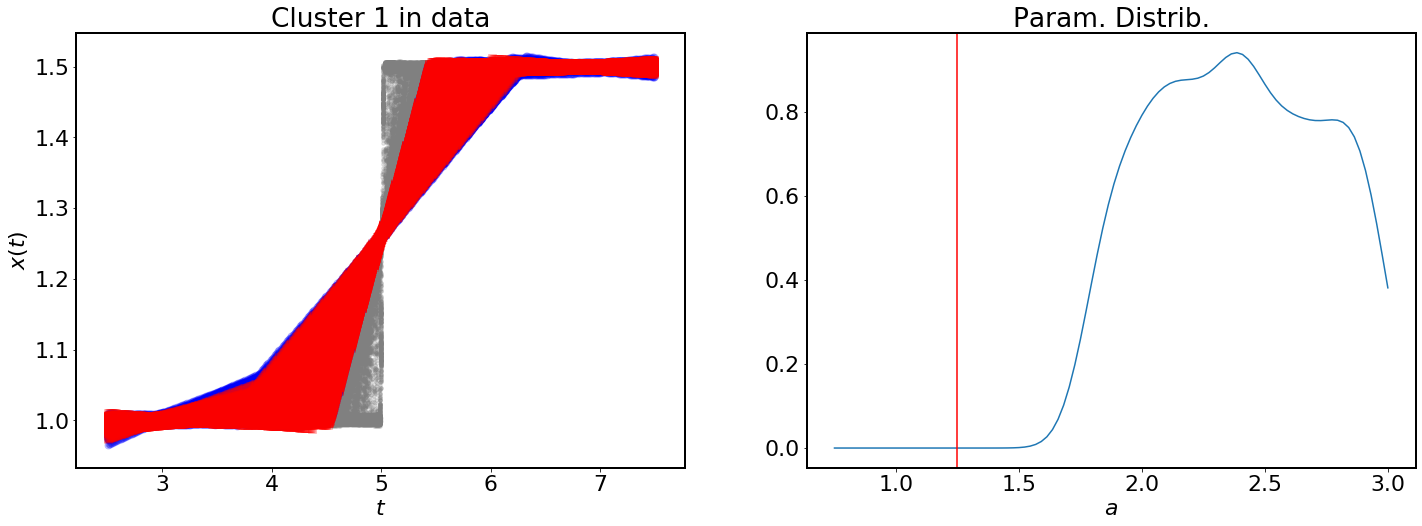

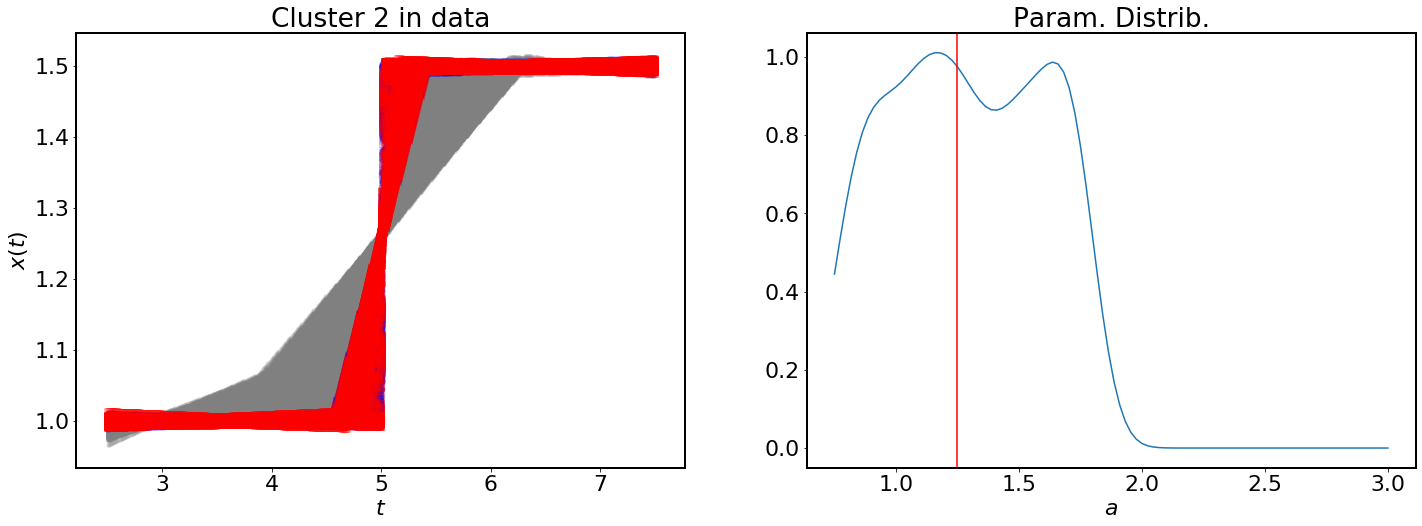

In [26]:
# # Plot clusters of predicted time series
# for j in range(learn.num_clusters):
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,2.5), gridspec_kw={'width_ratios': [3, 1]}) #(figsize=(10,5))
#     ps = []
#     for i in range(num_samples):
#         if learn2.predict_labels[i] == j:
#             ps.append(params[i,0])
#             ax1.plot(learn2.clean_times, learn2.clean_predictions[i, :])
#             #ax2.plot(times[time_start_idx : time_end_idx + 1], predicted_time_series[i, time_start_idx : time_end_idx + 1])
#     ax1.set(title='Cluster ' + str(j))
#     xs = np.linspace(param_range[0, 0], param_range[0,1], 100)
#     ax2.plot(xs, GKDE(ps)(xs))
#     ax2.set(xlabel=param_labels[0], title='Param. Distrib.')

# # Plot clusters of predicted time series
num_clean_obs2 = learn2.clean_times.shape[0]
for j in range(learn2.num_clusters):
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(24,8), gridspec_kw={'width_ratios': [1, 1]}) 
    ax1.scatter(np.tile(learn2.clean_times,num_samples).reshape(num_samples, num_clean_obs2), 
                learn2.clean_predictions, 50, c='gray', marker='.', alpha=0.2)
    idx = np.where(learn2.predict_labels == j)[0]
    ax1.scatter(np.tile(learn2.clean_times,len(idx)).reshape(len(idx),num_clean_obs2), 
                learn2.clean_predictions[idx,:], 50, c='b', marker='o', alpha=0.2)
    idx2 = np.where(learn2.obs_labels == j)[0]    
    ax1.scatter(np.tile(learn2.clean_times,len(idx2)).reshape(len(idx2),num_clean_obs), 
                learn2.clean_obs[idx2, :], 50, c='r', marker='s', alpha=0.2)
    ax1.set(title='Cluster ' + str(j+1) + ' in data')
    ax1.set_xlabel('$t$')
    ax1.set_ylabel('$x(t)$')
    
    xs = np.linspace(param_range[0, 0], param_range[0, 1], 100)
    ax2.plot(xs, GKDE(params[idx].flat[:])(xs))
    ax2.axvline(x=1.25, ymin=0.0, ymax=1.0, color='r')

    ax2.set(xlabel=param_labels[0], title='Param. Distrib.')
    
#     ax2.scatter(params[:,0], params[:,1], 30, c='gray', marker='.', alpha=0.2)
#     ax2.scatter(params[idx,0], params[idx,1], 50, c='blue', marker='o')
#     ax2.set(title='Cluster ' + str(j+1) + ' in parameters')
#     ax2.set_ylabel(param_labels[1])
#     ax2.set_xlabel(param_labels[0])
#     xs = np.linspace(param_range[0,0], param_range[0,1], 100)
#     ys1 = np.sqrt(0.5*(1.0 - np.sqrt(1.0 - 8.0*xs) -2.0*xs))
#     ys2 = np.sqrt(0.5*(1.0 + np.sqrt(1.0 - 8.0*xs) -2.0*xs))
#     ax2.plot(xs, ys1, 'r-', linewidth=3)
#     ax2.plot(xs, ys2, 'r-', linewidth=3)
    fig.tight_layout

In [27]:
# # Plot observed and predicted clusters
# for j in range(learn2.num_clusters):
#     plt.figure()
#     cluster_num = j
#     for i in range(num_samples):
#         if learn2.predict_labels[i] == cluster_num:
#             plt.plot(learn2.clean_times, learn2.clean_predictions[i,:],'b*')
#     for i in range(num_obs2):
#         if learn2.obs_labels[i] == cluster_num:
#             plt.plot(learn2.clean_times, learn2.clean_obs[i,:],'ro')

In [28]:
# Find best KPCA transformation for given number of QoI and transform time series data.
predict_map2, obs_map2 = learn2.learn_qois_and_transform(num_qoi=1) #variance_rate=0.95) #num_qoi=1)

1 principal components explain 50.9541% of variance for cluster 0 with {'kernel': 'linear'}
1 principal components explain 18.0481% of variance for cluster 0 with {'kernel': 'rbf'}
1 principal components explain 51.0022% of variance for cluster 0 with {'kernel': 'sigmoid'}
1 principal components explain 30.5207% of variance for cluster 0 with {'kernel': 'poly'}
1 principal components explain 42.4623% of variance for cluster 0 with {'kernel': 'cosine'}
Best kPCA for cluster  0  is  {'kernel': 'sigmoid'}
1 principal components explain 51.0022% of variance.
1 principal components explain 28.3004% of variance for cluster 1 with {'kernel': 'linear'}
1 principal components explain 11.0549% of variance for cluster 1 with {'kernel': 'rbf'}
1 principal components explain 25.2856% of variance for cluster 1 with {'kernel': 'sigmoid'}
1 principal components explain 12.6547% of variance for cluster 1 with {'kernel': 'poly'}
1 principal components explain 26.1456% of variance for cluster 1 with {'ke

In [29]:
%reset -f out

def plot_gap(all_eig_vals, n, cluster):
    fig = plt.figure(figsize=(10,10))
    fig.clear()
    #Plotting until maximum number of knots
    eig_vals = all_eig_vals[cluster].lambdas_[0:10]
    plt.semilogy(np.arange(np.size(eig_vals))+1,eig_vals/np.sum(eig_vals)*100, Marker='.', MarkerSize=20, linestyle='')
    plt.semilogy(np.arange(np.size(eig_vals))+1,eig_vals[n]/np.sum(eig_vals)*100*np.ones(np.size(eig_vals)), 'k--')
    plt.semilogy(np.arange(np.size(eig_vals))+1,eig_vals[n+1]/np.sum(eig_vals)*100*np.ones(np.size(eig_vals)), 'r--')
    plt.text(n+1, eig_vals[n]/np.sum(eig_vals)*150, 
             r'%2.3f' %(np.sum(eig_vals[0:n+1])/np.sum(eig_vals)*100) + '% of variation explained by first ' + '%1d' %(n+1) + ' PCs.', 
                                                               {'color': 'k', 'fontsize': 20})
    plt.text(n+2, eig_vals[n+1]/np.sum(eig_vals)*150, 
             r'Order of magnitude of gap is %4.2f.' %(np.log10(eig_vals[n])-np.log10(eig_vals[n+1])), 
                                                               {'color': 'r', 'fontsize': 20})
    s = 'Determining QoI for cluster #%1d' %(cluster+1)
    plt.title(s)
    plt.xlabel('Principal Component #')
    plt.ylabel('% of Variation')
    plt.xlim([0.1, np.size(eig_vals)+1])
    plt.ylim([0,500])


wd.interact(plot_gap, all_eig_vals=wd.fixed(learn2.kpcas),
            n = wd.IntSlider(value=0, min=0, max=5),
            cluster = wd.IntSlider(value=0, min=0, max=learn2.num_clusters-1))

Flushing output cache (2 entries)


interactive(children=(IntSlider(value=0, description='n', max=5), IntSlider(value=0, description='cluster', ma…

<function __main__.plot_gap(all_eig_vals, n, cluster)>

In [30]:
# Generate kernel density estimates on new QoI
learn2.generate_kdes()
# Calculate rejection rates for each cluster and print averages.
r_vals2=learn2.compute_r()

Diagnostic for clusters [sample average of ratios in each cluster]: [1.005922611923083, 0.9790153818485702]


In [31]:
# Compute marginal probablities for each parameter and initial condition.
param2_marginals = []
true_param_marginals = []
lam_ptr2 = []
cluster_weights2 = []
for i in range(learn2.num_clusters):
    lam_ptr2.append(np.where(learn2.predict_labels == i)[0])
    cluster_weights2.append(len(np.where(learn2.obs_labels == i)[0]) / num_obs)

for i in range(params.shape[1]):
    true_param_marginals.append(GKDE(params_obs2[:,i]))
    param2_marginals.append([])
    for j in range(learn2.num_clusters):
        param2_marginals[i].append(GKDE(params[lam_ptr2[j], i], weights=learn2.r[j]))

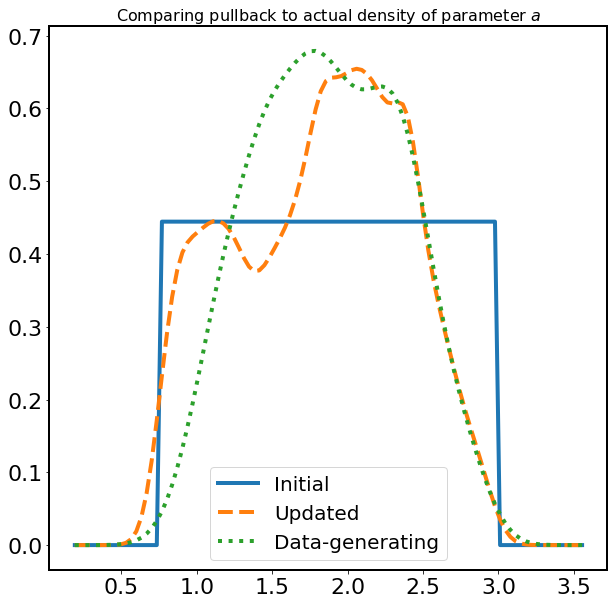

In [32]:
# Plot predicted marginal densities for parameters

for i in range(params.shape[1]):
    fig = plt.figure(figsize=(10,10))
    fig.clear()
    x_min = min(min(params[:, i]), min(params_obs[:, i]))
    x_max = max(max(params[:, i]), max(params_obs[:, i]))
    delt = 0.25*(x_max - x_min)
    x = np.linspace(x_min-delt, x_max+delt, 100)
    plt.plot(x, unif_dist(x, param_range[i, :]),
         label = 'Initial', linewidth=4)
    mar = np.zeros(x.shape)
    for j in range(learn2.num_clusters):
        mar += param2_marginals[i][j](x) * cluster_weights2[j]
    plt.plot(x, mar, label = 'Updated', linewidth=4, linestyle='dashed')
    plt.plot(x, true_param_marginals[i](x), label = 'Data-generating', 
             linewidth=4, linestyle='dotted')
    plt.title('Comparing pullback to actual density of parameter ' + param_labels[i], fontsize=16)
    plt.legend(fontsize=20)

In [33]:
# for i in range(params.shape[1]):
#     param_num=i
#     TV_metric = quad(param_init_error,param_range[i,0],param_range[i,1],maxiter=1000)
#     print(TV_metric)

In [34]:
def param2_update_KDE_error(x):
    mar = np.zeros(x.shape)
    for j in range(learn2.num_clusters):
        mar += param2_marginals[param_num][j](x) * cluster_weights2[j]
    return np.abs(mar-true_param_marginals[param_num](x))

for i in range(params.shape[1]):
    param_num=i
    TV_metric = quad(param2_update_KDE_error,param_range[i,0],param_range[i,1],maxiter=1000)
    print(TV_metric)

(0.19194620701236123, 7.117370914855314e-09)


In [35]:
# for i in range(params.shape[1]):
#     param_num=i
#     TV_metric = quad(KDE_error,param_range[i,0],param_range[i,1],maxiter=1000)
#     print(TV_metric)